In [115]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pl.read_csv(DATA_PATH / file_name, try_parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

In [116]:
# Inspect column names and first few rows of key dataframes
print("Inventory Columns:", inventory_df.columns)
print("Inventory Head:\n", inventory_df.head())

print("\nPurchase Orders Columns:", purchase_df.columns)
print("Purchase Orders Head:\n", purchase_df.head())

print("\nDeployments Columns:", deployments_df.columns)
print("Deployments Head:\n", deployments_df.head())

print("\nSites Columns:", sites_df.columns)
print("Sites Head:\n", sites_df.head())

Inventory Columns: ['site_id', 'sku_id', 'snapshot_date', 'on_hand_qty', 'allocated_qty', 'in_transit_qty']
Inventory Head:
 shape: (5, 6)
┌──────────┬───────────┬───────────────┬─────────────┬───────────────┬────────────────┐
│ site_id  ┆ sku_id    ┆ snapshot_date ┆ on_hand_qty ┆ allocated_qty ┆ in_transit_qty │
│ ---      ┆ ---       ┆ ---           ┆ ---         ┆ ---           ┆ ---            │
│ str      ┆ str       ┆ date          ┆ i64         ┆ i64           ┆ i64            │
╞══════════╪═══════════╪═══════════════╪═════════════╪═══════════════╪════════════════╡
│ ST-01489 ┆ SKU-03098 ┆ 2025-10-03    ┆ 9           ┆ 4             ┆ 2              │
│ ST-00841 ┆ SKU-00755 ┆ 2025-01-08    ┆ 18          ┆ 2             ┆ 3              │
│ ST-00771 ┆ SKU-01482 ┆ 2025-04-08    ┆ 7           ┆ 2             ┆ 4              │
│ ST-01017 ┆ SKU-00406 ┆ 2024-12-22    ┆ 9           ┆ 6             ┆ 2              │
│ ST-01897 ┆ SKU-02690 ┆ 2025-01-31    ┆ 10          ┆ 4             

In [117]:
# Check site types per country to see if we can map POs to specific sites
site_types_per_country = sites_df.group_by(["country", "site_type"]).len().sort("country")
print(site_types_per_country.head(10))

# Check if there are countries with multiple Warehouses
warehouses = sites_df.filter(pl.col("site_type") == "Warehouse")
print("\nWarehouses per country:")
print(warehouses.group_by("country").len().filter(pl.col("len") > 1))


shape: (10, 3)
┌───────────┬────────────────────┬─────┐
│ country   ┆ site_type          ┆ len │
│ ---       ┆ ---                ┆ --- │
│ str       ┆ str                ┆ u32 │
╞═══════════╪════════════════════╪═════╡
│ Argentina ┆ Data Center        ┆ 5   │
│ Argentina ┆ Warehouse          ┆ 12  │
│ Argentina ┆ Integration Center ┆ 9   │
│ Argentina ┆ Cell Site          ┆ 25  │
│ Australia ┆ Data Center        ┆ 3   │
│ Australia ┆ Warehouse          ┆ 8   │
│ Australia ┆ Integration Center ┆ 3   │
│ Australia ┆ Cell Site          ┆ 30  │
│ Austria   ┆ Cell Site          ┆ 66  │
│ Austria   ┆ Warehouse          ┆ 34  │
└───────────┴────────────────────┴─────┘

Warehouses per country:
shape: (27, 2)
┌─────────────┬─────┐
│ country     ┆ len │
│ ---         ┆ --- │
│ str         ┆ u32 │
╞═════════════╪═════╡
│ Italy       ┆ 21  │
│ USA         ┆ 11  │
│ Thailand    ┆ 9   │
│ Japan       ┆ 14  │
│ Australia   ┆ 8   │
│ …           ┆ …   │
│ Argentina   ┆ 12  │
│ Vietnam     ┆ 7   │
│ F

In [118]:
# Join deployments with sites to check site_type
deployments_with_type = deployments_df.join(sites_df, on="site_id", how="left")
print("Deployments Site Types:")
print(deployments_with_type.group_by("site_type").len())

# Join inventory with sites to check site_type
inventory_with_type = inventory_df.join(sites_df, on="site_id", how="left")
print("\nInventory Site Types:")
print(inventory_with_type.group_by("site_type").len())


Deployments Site Types:
shape: (2, 2)
┌─────────────┬───────┐
│ site_type   ┆ len   │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ Cell Site   ┆ 67281 │
│ Data Center ┆ 12719 │
└─────────────┴───────┘

Inventory Site Types:
shape: (4, 2)
┌────────────────────┬────────┐
│ site_type          ┆ len    │
│ ---                ┆ ---    │
│ str                ┆ u32    │
╞════════════════════╪════════╡
│ Cell Site          ┆ 109222 │
│ Warehouse          ┆ 48629  │
│ Data Center        ┆ 20753  │
│ Integration Center ┆ 21396  │
└────────────────────┴────────┘


In [119]:
# Check uniqueness of Warehouse per (Country, SKU) in Inventory
# Filter inventory for Warehouses
wh_inventory = inventory_with_type.filter(pl.col("site_type") == "Warehouse")

# Count distinct Warehouses per (Country, SKU)
wh_per_country_sku = wh_inventory.group_by(["country", "sku_id"]).agg(pl.col("site_id").n_unique().alias("n_warehouses"))

print("Warehouses per (Country, SKU) distribution:")
print(wh_per_country_sku.group_by("n_warehouses").len())

# Check if we have (Country, SKU) in POs that are not in Inventory
# ... (later)


Warehouses per (Country, SKU) distribution:
shape: (6, 2)
┌──────────────┬───────┐
│ n_warehouses ┆ len   │
│ ---          ┆ ---   │
│ u32          ┆ u32   │
╞══════════════╪═══════╡
│ 3            ┆ 1012  │
│ 1            ┆ 31688 │
│ 2            ┆ 6393  │
│ 5            ┆ 19    │
│ 6            ┆ 1     │
│ 4            ┆ 138   │
└──────────────┴───────┘


Inventory Start Head:
shape: (5, 9)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ site_id  ┆ sku_id    ┆ snapshot_ ┆ on_hand_q ┆ … ┆ in_transi ┆ effective ┆ country   ┆ site_type │
│ ---      ┆ ---       ┆ date      ┆ ty        ┆   ┆ t_qty     ┆ _stock    ┆ ---       ┆ ---       │
│ str      ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ str       │
│          ┆           ┆ date      ┆ i64       ┆   ┆ i64       ┆ i64       ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ST-00295 ┆ SKU-03956 ┆ 2024-11-1 ┆ 8         ┆ … ┆ 3         ┆ 6         ┆ Italy     ┆ Cell Site │
│          ┆           ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆           │
│ ST-00316 ┆ SKU-03473 ┆ 2024-11-2 ┆ 10        ┆ … ┆ 3         ┆ 9         ┆ Germany   ┆ Warehouse │
│          ┆           ┆ 8         ┆           ┆   ┆   

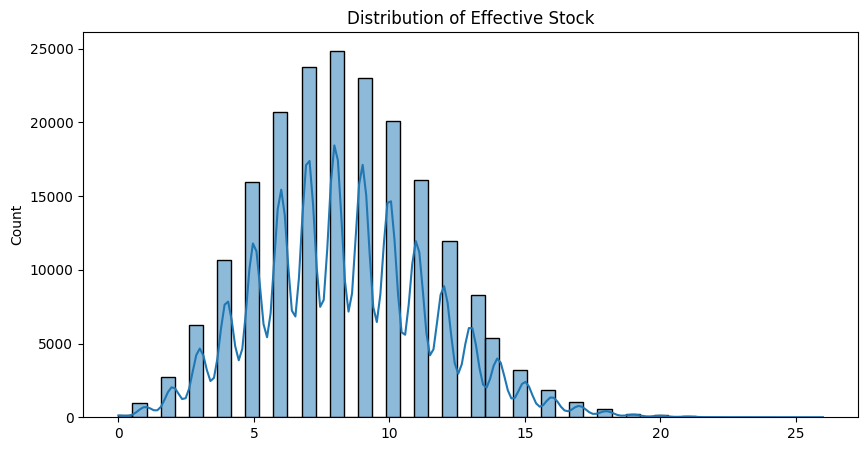

In [120]:
# --- Step 1: Starting Inventory ---

# Get latest snapshot per site/sku
# Assuming the file contains history, we sort by date and take last
inventory_latest = (
    inventory_df
    .sort("snapshot_date")
    .group_by(["site_id", "sku_id"])
    .last()
)

# Calculate effective stock
inventory_start = inventory_latest.with_columns(
    (pl.col("on_hand_qty") - pl.col("allocated_qty") + pl.col("in_transit_qty")).alias("effective_stock")
)

# Join with sites to get Country (needed for PO mapping)
inventory_start = inventory_start.join(sites_df.select(["site_id", "country", "site_type"]), on="site_id", how="left")

print("Inventory Start Head:")
print(inventory_start.head())

# Visualize distribution of effective stock
plt.figure(figsize=(10, 5))
sns.histplot(inventory_start["effective_stock"].to_numpy(), bins=50, kde=True)
plt.title("Distribution of Effective Stock")
plt.show()


In [121]:
# Build site mapping per (country, sku) prioritizing warehouses
warehouse_priority = (
    inventory_start
    .filter(pl.col("site_type") == "Warehouse")
    .sort(["country", "sku_id", "effective_stock"], descending=[False, False, True])
)
warehouse_choice = (
    warehouse_priority
    .group_by(["country", "sku_id"])
    .agg(pl.col("site_id").first().alias("preferred_site"))
)

fallback_choice = (
    inventory_start
    .sort(["country", "sku_id", "effective_stock"], descending=[False, False, True])
    .group_by(["country", "sku_id"])
    .agg(pl.col("site_id").first().alias("fallback_site"))
)

country_sku_site_map = (
    fallback_choice
    .join(warehouse_choice, on=["country", "sku_id"], how="left")
    .with_columns(
        pl.coalesce(pl.col("preferred_site"), pl.col("fallback_site")).alias("forecast_site_id")
    )
    .select(["country", "sku_id", "forecast_site_id"])
)

print("Country/SKU mappings:", country_sku_site_map.height)


Country/SKU mappings: 98488


In [122]:
# Determine reference date for forecast horizon (latest snapshot)
forecast_start_date = inventory_start["snapshot_date"].max()
print(f"Forecast reference date: {forecast_start_date}")

Forecast reference date: 2025-10-31


PO rows mapped to forecast sites: 79.21%
Inbound supply sample:
shape: (5, 4)
┌──────────┬───────────┬────────────────┬─────────────┐
│ site     ┆ sku_id    ┆ horizon_bucket ┆ inbound_qty │
│ ---      ┆ ---       ┆ ---            ┆ ---         │
│ str      ┆ str       ┆ str            ┆ i64         │
╞══════════╪═══════════╪════════════════╪═════════════╡
│ ST-01267 ┆ SKU-02272 ┆ 0-30d          ┆ 12          │
│ ST-01267 ┆ SKU-00825 ┆ 0-30d          ┆ 9           │
│ ST-01174 ┆ SKU-01793 ┆ 0-30d          ┆ 7           │
│ ST-01630 ┆ SKU-01341 ┆ 0-30d          ┆ 8           │
│ ST-00344 ┆ SKU-01153 ┆ 0-30d          ┆ 10          │
└──────────┴───────────┴────────────────┴─────────────┘

Inbound totals by bucket:
shape: (2, 2)
┌────────────────┬───────────────┐
│ horizon_bucket ┆ total_inbound │
│ ---            ┆ ---           │
│ str            ┆ i64           │
╞════════════════╪═══════════════╡
│ 0-30d          ┆ 6973          │
│ 31-60d         ┆ 830           │
└────────────────┴──

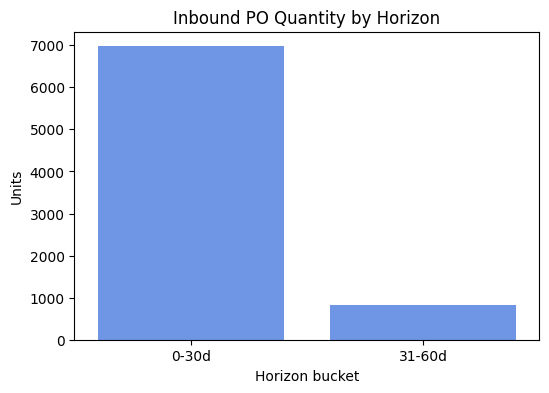


Top 10 inbound site/SKU pairs within 30 days:
shape: (10, 4)
┌──────────┬───────────┬────────────────┬─────────────┐
│ site     ┆ sku_id    ┆ horizon_bucket ┆ inbound_qty │
│ ---      ┆ ---       ┆ ---            ┆ ---         │
│ str      ┆ str       ┆ str            ┆ i64         │
╞══════════╪═══════════╪════════════════╪═════════════╡
│ ST-01999 ┆ SKU-02989 ┆ 0-30d          ┆ 19          │
│ ST-00762 ┆ SKU-00286 ┆ 0-30d          ┆ 18          │
│ ST-00047 ┆ SKU-02364 ┆ 0-30d          ┆ 17          │
│ ST-01043 ┆ SKU-03157 ┆ 0-30d          ┆ 17          │
│ ST-01560 ┆ SKU-00969 ┆ 0-30d          ┆ 17          │
│ ST-00709 ┆ SKU-02764 ┆ 0-30d          ┆ 17          │
│ ST-01697 ┆ SKU-03007 ┆ 0-30d          ┆ 17          │
│ ST-01069 ┆ SKU-02136 ┆ 0-30d          ┆ 17          │
│ ST-00975 ┆ SKU-02950 ┆ 0-30d          ┆ 17          │
│ ST-00714 ┆ SKU-01221 ┆ 0-30d          ┆ 17          │
└──────────┴───────────┴────────────────┴─────────────┘


In [123]:
# --- Step 2: Planned inbound supply from open POs ---

# Filter POs that are open and promised after the snapshot reference
days_horizon = 90
open_po = (
    purchase_df
    .filter(pl.col("status") == "Open")
    .with_columns(
        (
            pl.col("promised_date").cast(pl.Date) - pl.lit(forecast_start_date)
        ).dt.total_days().alias("days_out")
    )
    .filter(pl.col("days_out") >= 0)
)

# Bucket into 30/60/90 windows
open_po = open_po.with_columns(
    pl.when(pl.col("days_out") <= 30)
    .then(pl.lit("0-30d"))
    .when(pl.col("days_out") <= 60)
    .then(pl.lit("31-60d"))
    .when(pl.col("days_out") <= 90)
    .then(pl.lit("61-90d"))
    .otherwise(pl.lit(">90d"))
    .alias("horizon_bucket")
)

# Attach forecast site based on (country, sku) coverage
open_po_sites = open_po.join(country_sku_site_map, on=["country", "sku_id"], how="left")
matched_ratio = open_po_sites.filter(pl.col("forecast_site_id").is_not_null()).height / max(open_po_sites.height, 1)
print(f"PO rows mapped to forecast sites: {matched_ratio:.2%}")

# Aggregate inbound supply per site/sku/bucket
inbound_supply = (
    open_po_sites
    .filter((pl.col("horizon_bucket") != ">90d") & pl.col("forecast_site_id").is_not_null())
    .group_by(["forecast_site_id", "sku_id", "horizon_bucket"])
    .agg(pl.col("order_qty").sum().alias("inbound_qty"))
    .rename({"forecast_site_id": "site"})
)

print("Inbound supply sample:")
print(inbound_supply.head())

# Summary stats per bucket
bucket_totals = (
    open_po_sites
    .filter((pl.col("horizon_bucket") != ">90d") & pl.col("forecast_site_id").is_not_null())
    .group_by("horizon_bucket")
    .agg(pl.col("order_qty").sum().alias("total_inbound"))
    .sort("horizon_bucket")
)
print("\nInbound totals by bucket:")
print(bucket_totals)

# Plot inbound quantity by bucket
plt.figure(figsize=(6,4))
sns.barplot(data=bucket_totals.to_pandas(), x="horizon_bucket", y="total_inbound", color="#5B8FF9")
plt.title("Inbound PO Quantity by Horizon")
plt.ylabel("Units")
plt.xlabel("Horizon bucket")
plt.show()

# Top 10 site/SKU combinations driving near-term inbound
top_inbound = (
    inbound_supply
    .filter(pl.col("horizon_bucket") == "0-30d")
    .sort("inbound_qty", descending=True)
    .head(10)
)
print("\nTop 10 inbound site/SKU pairs within 30 days:")
print(top_inbound)


Project demand sample:
shape: (5, 4)
┌───────────────┬───────────┬────────────────┬────────────┐
│ forecast_site ┆ sku_id    ┆ horizon_bucket ┆ demand_qty │
│ ---           ┆ ---       ┆ ---            ┆ ---        │
│ str           ┆ str       ┆ str            ┆ f64        │
╞═══════════════╪═══════════╪════════════════╪════════════╡
│ ST-00658      ┆ SKU-04652 ┆ 0-30d          ┆ 1.0        │
│ ST-01178      ┆ SKU-02374 ┆ 0-30d          ┆ 1.0        │
│ ST-01955      ┆ SKU-03721 ┆ 0-30d          ┆ 3.0        │
│ ST-01210      ┆ SKU-04255 ┆ 0-30d          ┆ 5.0        │
│ ST-00216      ┆ SKU-03634 ┆ 0-30d          ┆ 5.0        │
└───────────────┴───────────┴────────────────┴────────────┘

Project demand totals by bucket:
shape: (2, 2)
┌────────────────┬──────────────┐
│ horizon_bucket ┆ total_demand │
│ ---            ┆ ---          │
│ str            ┆ f64          │
╞════════════════╪══════════════╡
│ 0-30d          ┆ 1478.0       │
│ 31-60d         ┆ 59.0         │
└────────────────

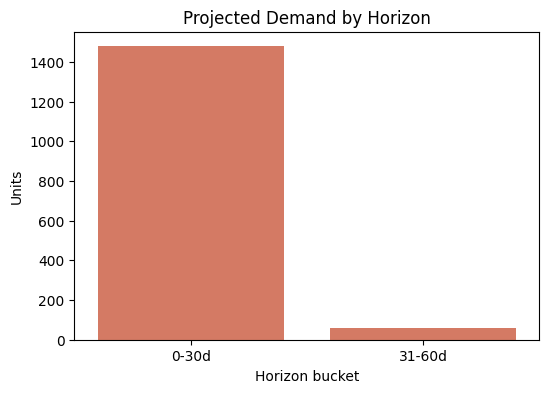


Top 10 site/SKU demand pairs within 30 days:
shape: (10, 4)
┌───────────────┬───────────┬────────────────┬────────────┐
│ forecast_site ┆ sku_id    ┆ horizon_bucket ┆ demand_qty │
│ ---           ┆ ---       ┆ ---            ┆ ---        │
│ str           ┆ str       ┆ str            ┆ f64        │
╞═══════════════╪═══════════╪════════════════╪════════════╡
│ ST-01711      ┆ SKU-00555 ┆ 0-30d          ┆ 11.0       │
│ ST-01925      ┆ SKU-00630 ┆ 0-30d          ┆ 10.0       │
│ ST-00622      ┆ SKU-00592 ┆ 0-30d          ┆ 10.0       │
│ ST-01497      ┆ SKU-04607 ┆ 0-30d          ┆ 9.0        │
│ ST-00835      ┆ SKU-03925 ┆ 0-30d          ┆ 9.0        │
│ ST-00487      ┆ SKU-00999 ┆ 0-30d          ┆ 9.0        │
│ ST-01326      ┆ SKU-01843 ┆ 0-30d          ┆ 9.0        │
│ ST-01903      ┆ SKU-01672 ┆ 0-30d          ┆ 9.0        │
│ ST-00682      ┆ SKU-04412 ┆ 0-30d          ┆ 8.0        │
│ ST-01421      ┆ SKU-04499 ┆ 0-30d          ┆ 8.0        │
└───────────────┴───────────┴──────────

In [124]:
# --- Step 3: Project-driven outbound demand ---

# Collapse deployments to a single event date (actual overrides planned)
deployment_events = (
    deployments_df
    .with_columns(
        pl.when(pl.col("actual_date").is_not_null())
        .then(pl.col("actual_date"))
        .otherwise(pl.col("planned_date"))
        .alias("event_date")
    )
    .filter(pl.col("event_date").is_not_null())
    .with_columns(pl.col("event_date").cast(pl.Date))
)

# Focus on events from the reference date onward
deployment_future = (
    deployment_events
    .with_columns(
        (pl.col("event_date") - pl.lit(forecast_start_date)).dt.total_days().alias("days_out")
    )
    .filter(pl.col("days_out") >= 0)
)

# Bucket events into horizons similar to inbound
deployment_future = deployment_future.with_columns(
    pl.when(pl.col("days_out") <= 30)
    .then(pl.lit("0-30d"))
    .when(pl.col("days_out") <= 60)
    .then(pl.lit("31-60d"))
    .when(pl.col("days_out") <= 90)
    .then(pl.lit("61-90d"))
    .otherwise(pl.lit(">90d"))
    .alias("horizon_bucket")
)

# Enrich with site country and map to forecast site ids
deployment_future = deployment_future.join(
    sites_df.select(["site_id", "country", "site_type"]), on="site_id", how="left"
)

deployment_future = deployment_future.join(
    country_sku_site_map, on=["country", "sku_id"], how="left"
)

deployment_future = deployment_future.with_columns(
    pl.when(pl.col("site_id").is_in(warehouse_site_ids))
    .then(pl.col("site_id"))
    .otherwise(pl.col("forecast_site_id"))
    .alias("forecast_site")
)

deployment_future = deployment_future.filter(pl.col("forecast_site").is_not_null())

# Bring allocated qty aligned to forecast site
allocation_context = (
    inventory_start
    .select(["site_id", "sku_id", "allocated_qty"])
    .rename({"site_id": "forecast_site"})
)

deployment_alloc = (
    deployment_future
    .join(allocation_context, on=["forecast_site", "sku_id"], how="left")
    .with_columns(pl.col("allocated_qty").fill_null(0).alias("allocated_qty"))
)

# Count outstanding deployments per forecast site/SKU
future_counts = (
    deployment_alloc
    .group_by(["forecast_site", "sku_id"])
    .len()
    .rename({"len": "future_events"})
)

deployment_alloc = deployment_alloc.join(future_counts, on=["forecast_site", "sku_id"], how="left")

# Convert allocated units into per-event demand. If nothing is allocated yet, assume 1 unit per project.
deployment_alloc = deployment_alloc.with_columns(
    pl.when(pl.col("future_events") > 0)
    .then(
        pl.when(pl.col("allocated_qty") > 0)
        .then(pl.col("allocated_qty") / pl.col("future_events"))
        .otherwise(pl.lit(1.0))
    )
    .otherwise(0.0)
    .alias("event_demand")
)

project_demand = (
    deployment_alloc
    .filter(pl.col("horizon_bucket") != ">90d")
    .group_by(["forecast_site", "sku_id", "horizon_bucket"])
    .agg(pl.col("event_demand").sum().alias("demand_qty"))
)

print("Project demand sample:")
print(project_demand.head())

# Totals per bucket
project_bucket_totals = (
    deployment_alloc
    .filter(pl.col("horizon_bucket") != ">90d")
    .group_by("horizon_bucket")
    .agg(pl.col("event_demand").sum().alias("total_demand"))
    .sort("horizon_bucket")
)
print("\nProject demand totals by bucket:")
print(project_bucket_totals)

# Visualization
plt.figure(figsize=(6,4))
sns.barplot(data=project_bucket_totals.to_pandas(), x="horizon_bucket", y="total_demand", color="#E76F51")
plt.title("Projected Demand by Horizon")
plt.ylabel("Units")
plt.xlabel("Horizon bucket")
plt.show()

# Top consuming site/SKU pairs in next 30 days
top_demand = (
    project_demand
    .filter(pl.col("horizon_bucket") == "0-30d")
    .sort("demand_qty", descending=True)
    .head(10)
)
print("\nTop 10 site/SKU demand pairs within 30 days:")
print(top_demand)


In [125]:
# Diagnostics: check overlap between inventory, inbound, and demand keys
warehouse_pairs = (
    inventory_start
    .filter(pl.col("site_type") == "Warehouse")
    .select(["site_id", "sku_id"])
    .rename({"site_id": "site", "sku_id": "sku"})
    .unique()
)

inbound_pairs = inbound_supply.rename({"sku_id": "sku"}).select(["site", "sku"]).unique()
project_pairs = project_demand.rename({"forecast_site": "site", "sku_id": "sku"}).select(["site", "sku"]).unique()

print("Warehouse pairs:", warehouse_pairs.height)
print("Inbound pairs:", inbound_pairs.height)
print("Project pairs:", project_pairs.height)

intersection_inbound = warehouse_pairs.join(inbound_pairs, on=["site", "sku"], how="inner").height
intersection_project = warehouse_pairs.join(project_pairs, on=["site", "sku"], how="inner").height
print("Overlap warehouse vs inbound:", intersection_inbound)
print("Overlap warehouse vs project:", intersection_project)

Warehouse pairs: 48163
Inbound pairs: 863
Project pairs: 410
Overlap warehouse vs inbound: 389
Overlap warehouse vs project: 173


In [126]:
# Cache list of warehouse site ids for mapping
warehouse_site_ids = (
    inventory_start
    .filter(pl.col("site_type") == "Warehouse")
    .select("site_id")
    .get_column("site_id")
    .unique()
    .to_list()
)
print("Warehouse site count:", len(warehouse_site_ids))

Warehouse site count: 487


Forecast sample:
shape: (5, 8)
┌──────────┬───────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┐
│ site     ┆ sku       ┆ effective_ ┆ inbound_0- ┆ demand_0-3 ┆ forecast_0 ┆ forecast_ ┆ forecast_ │
│ ---      ┆ ---       ┆ stock      ┆ 30d        ┆ 0d         ┆ -30d       ┆ 31-60d    ┆ 61-90d    │
│ str      ┆ str       ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│          ┆           ┆ i64        ┆ i64        ┆ f64        ┆ f64        ┆ f64       ┆ f64       │
╞══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╡
│ ST-00316 ┆ SKU-03473 ┆ 9          ┆ 0          ┆ 0.0        ┆ 9.0        ┆ 9.0       ┆ 9.0       │
│ ST-00221 ┆ SKU-04500 ┆ 7          ┆ 0          ┆ 0.0        ┆ 7.0        ┆ 7.0       ┆ 7.0       │
│ ST-00171 ┆ SKU-00998 ┆ 6          ┆ 0          ┆ 0.0        ┆ 6.0        ┆ 6.0       ┆ 6.0       │
│ ST-01283 ┆ SKU-04942 ┆ 12         ┆ 0          ┆ 0.0      

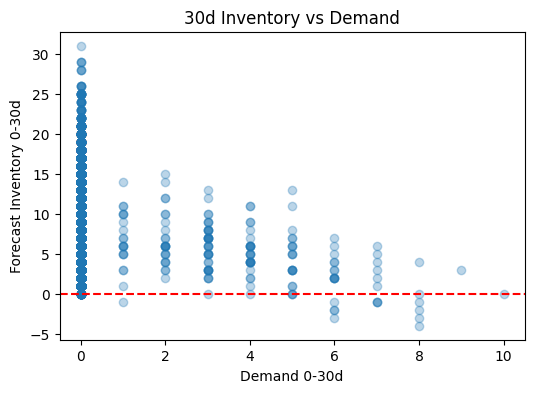


Forecast summary stats:
shape: (1, 5)
┌────────────────────┬─────────────────────┬─────────────────────┬──────────┬──────────┐
│ mean_forecast_0_30 ┆ mean_forecast_31_60 ┆ mean_forecast_61_90 ┆ p10_0_30 ┆ p90_0_30 │
│ ---                ┆ ---                 ┆ ---                 ┆ ---      ┆ ---      │
│ f64                ┆ f64                 ┆ f64                 ┆ f64      ┆ f64      │
╞════════════════════╪═════════════════════╪═════════════════════╪══════════╪══════════╡
│ 8.475739           ┆ 8.483442            ┆ 8.483442            ┆ 4.0      ┆ 13.0     │
└────────────────────┴─────────────────────┴─────────────────────┴──────────┴──────────┘


site,sku,effective_stock,inbound_0-30d,inbound_31-60d,inbound_61-90d,demand_0-30d,demand_31-60d,demand_61-90d,forecast_0-30d,forecast_31-60d,forecast_61-90d
str,str,i64,i64,i64,i32,f64,f64,i32,f64,f64,f64
"""ST-01421""","""SKU-04499""",4,0,0,0,8.0,0.0,0,-4.0,-4.0,-4.0
"""ST-00495""","""SKU-00437""",3,0,0,0,6.0,0.0,0,-3.0,-3.0,-3.0
"""ST-00682""","""SKU-04412""",5,0,0,0,8.0,0.0,0,-3.0,-3.0,-3.0
"""ST-00731""","""SKU-00935""",4,0,0,0,6.0,0.0,0,-2.0,-2.0,-2.0
"""ST-00284""","""SKU-03075""",4,0,0,0,6.0,0.0,0,-2.0,-2.0,-2.0


In [127]:
# --- Step 4: Combine into site/SKU forecast ---

# Helper to pivot bucket columns into wide format
def pivot_bucket(df, index_cols, bucket_col, value_col, prefix):
    if df.is_empty():
        return pl.DataFrame(index_cols + [f"{prefix}_0-30d", f"{prefix}_31-60d", f"{prefix}_61-90d"])
    pivoted = (
        df
        .pivot(
            on=bucket_col,
            index=index_cols,
            values=value_col,
            aggregate_function="sum"
        )
    )
    for label in ["0-30d", "31-60d", "61-90d"]:
        if label not in pivoted.columns:
            pivoted = pivoted.with_columns(pl.lit(0).alias(label))
        else:
            pivoted = pivoted.with_columns(pl.col(label).fill_null(0).alias(label))
    rename_map = {label: f"{prefix}_{label}" for label in ["0-30d", "31-60d", "61-90d"]}
    pivoted = pivoted.rename(rename_map)
    return pivoted

# Rename columns to align indices
inbound_pivot = pivot_bucket(inbound_supply.rename({"sku_id": "sku"}), ["site", "sku"], "horizon_bucket", "inbound_qty", "inbound")
project_pivot = pivot_bucket(project_demand.rename({"sku_id": "sku"}), ["forecast_site", "sku"], "horizon_bucket", "demand_qty", "demand").rename({"forecast_site": "site"})

# Starting inventory focus on forecast sites (warehouses preferred)
warehouse_inventory = (
    inventory_start
    .select(["site_id", "sku_id", "effective_stock", "site_type"])
    .rename({"site_id": "site", "sku_id": "sku"})
    .filter(pl.col("site_type") == "Warehouse")
    .drop("site_type")
)

# Combine data
forecast_full = (
    warehouse_inventory
    .join(inbound_pivot, on=["site", "sku"], how="left")
    .join(project_pivot, on=["site", "sku"], how="left")
)

for col in ["inbound_0-30d", "inbound_31-60d", "inbound_61-90d", "demand_0-30d", "demand_31-60d", "demand_61-90d"]:
    if col not in forecast_full.columns:
        forecast_full = forecast_full.with_columns(pl.lit(0).alias(col))
    else:
        forecast_full = forecast_full.with_columns(pl.col(col).fill_null(0).alias(col))

# Calculate cumulative forecast inventory per bucket
forecast_full = forecast_full.with_columns([
    (pl.col("effective_stock") + pl.col("inbound_0-30d") - pl.col("demand_0-30d")).alias("forecast_0-30d"),
    (pl.col("effective_stock") + pl.col("inbound_0-30d") + pl.col("inbound_31-60d") - pl.col("demand_0-30d") - pl.col("demand_31-60d")).alias("forecast_31-60d"),
    (pl.col("effective_stock") + pl.col("inbound_0-30d") + pl.col("inbound_31-60d") + pl.col("inbound_61-90d") - pl.col("demand_0-30d") - pl.col("demand_31-60d") - pl.col("demand_61-90d")).alias("forecast_61-90d")
])

print("Forecast sample:")
print(forecast_full.select(["site", "sku", "effective_stock", "inbound_0-30d", "demand_0-30d", "forecast_0-30d", "forecast_31-60d", "forecast_61-90d"]).head())

# Flag site/SKU pairs going negative
risk_sites = forecast_full.filter(pl.col("forecast_0-30d") < 0)
print(f"\nSites at risk within 30 days: {risk_sites.height}")
if risk_sites.height > 0:
    print(risk_sites.select(["site", "sku", "forecast_0-30d"]).head(10))

# Visualize inventory vs demand
plot_df = forecast_full.select([
    "demand_0-30d", "forecast_0-30d"
]).to_pandas()
plt.figure(figsize=(6,4))
plt.scatter(plot_df["demand_0-30d"], plot_df["forecast_0-30d"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Demand 0-30d")
plt.ylabel("Forecast Inventory 0-30d")
plt.title("30d Inventory vs Demand")
plt.show()

# Summary statistics
summary_metrics = forecast_full.select([
    pl.col("forecast_0-30d").mean().alias("mean_forecast_0_30"),
    pl.col("forecast_31-60d").mean().alias("mean_forecast_31_60"),
    pl.col("forecast_61-90d").mean().alias("mean_forecast_61_90"),
    pl.col("forecast_0-30d").quantile(0.1).alias("p10_0_30"),
    pl.col("forecast_0-30d").quantile(0.9).alias("p90_0_30")
])
print("\nForecast summary stats:")
print(summary_metrics)

forecast_full = forecast_full.sort("forecast_0-30d")
forecast_full.head()

In [ ]:
output_dir = (Path().cwd() / "outputs")
output_dir.mkdir(parents=True, exist_ok=True)
export_path = output_dir / "forecast_site_sku_30_90d.csv"
forecast_full.write_csv(export_path)
print(f"Forecast export saved to {export_path}")

## Additional validation and visualization
We will drill into the deterministic forecast to understand where inbound supply, project demand, and existing inventory diverge. The following cells add coverage diagnostics, per-site rollups, and visual summaries that highlight hotspots before layering on machine learning.

In [128]:
# Diagnostics on coverage and site-level rollups
total_pairs = forecast_full.height
coverage_metrics = [
    "Site-SKU pairs",
    "Inbound coverage %",
    "Project coverage %",
    "Risk share %"
 ]
coverage_values = [
    float(total_pairs),
    (forecast_full.filter(pl.col("inbound_0-30d") > 0).height / max(total_pairs, 1)) * 100,
    (forecast_full.filter(pl.col("demand_0-30d") > 0).height / max(total_pairs, 1)) * 100,
    (forecast_full.filter(pl.col("forecast_0-30d") < 0).height / max(total_pairs, 1)) * 100
 ]
coverage_stats = pl.DataFrame({
    "metric": coverage_metrics,
    "value": pl.Series(coverage_values, dtype=pl.Float64)
})
print("Coverage share (% where applicable):")
print(coverage_stats)

site_rollup = (
    forecast_full
    .with_columns([
        (pl.col("inbound_0-30d") + pl.col("inbound_31-60d") + pl.col("inbound_61-90d")).alias("inbound_0_90"),
        (pl.col("demand_0-30d") + pl.col("demand_31-60d") + pl.col("demand_61-90d")).alias("demand_0_90")
    ])
    .group_by("site")
    .agg([
        pl.sum("effective_stock").alias("effective_stock"),
        pl.sum("inbound_0_90").alias("inbound_0_90"),
        pl.sum("demand_0_90").alias("demand_0_90"),
        pl.sum("forecast_0-30d").alias("net_0_30"),
        pl.sum("forecast_31-60d").alias("net_31_60"),
        pl.sum("forecast_61-90d").alias("net_61_90"),
        pl.count().alias("sku_count")
    ])
    .sort("net_0_30")
)

print("\nBottom 10 sites by 30d net position:")
print(site_rollup.head(10))

print("\nTop 10 sites by 30d headroom:")
print(site_rollup.sort("net_0_30", descending=True).head(10))

Coverage share (% where applicable):
shape: (4, 2)
┌────────────────────┬──────────┐
│ metric             ┆ value    │
│ ---                ┆ ---      │
│ str                ┆ f64      │
╞════════════════════╪══════════╡
│ Site-SKU pairs     ┆ 48163.0  │
│ Inbound coverage % ┆ 0.72047  │
│ Project coverage % ┆ 0.348815 │
│ Risk share %       ┆ 0.024915 │
└────────────────────┴──────────┘

Bottom 10 sites by 30d net position:
shape: (10, 8)
┌──────────┬─────────────┬─────────────┬────────────┬──────────┬───────────┬───────────┬───────────┐
│ site     ┆ effective_s ┆ inbound_0_9 ┆ demand_0_9 ┆ net_0_30 ┆ net_31_60 ┆ net_61_90 ┆ sku_count │
│ ---      ┆ tock        ┆ 0           ┆ 0          ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
│ str      ┆ ---         ┆ ---         ┆ ---        ┆ f64      ┆ f64       ┆ f64       ┆ u32       │
│          ┆ i64         ┆ i64         ┆ f64        ┆          ┆           ┆           ┆           │
╞══════════╪═════════════╪═════════════╪═══════════

C:\Users\skibi\AppData\Local\Temp\ipykernel_37832\2226845151.py:36: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("sku_count")


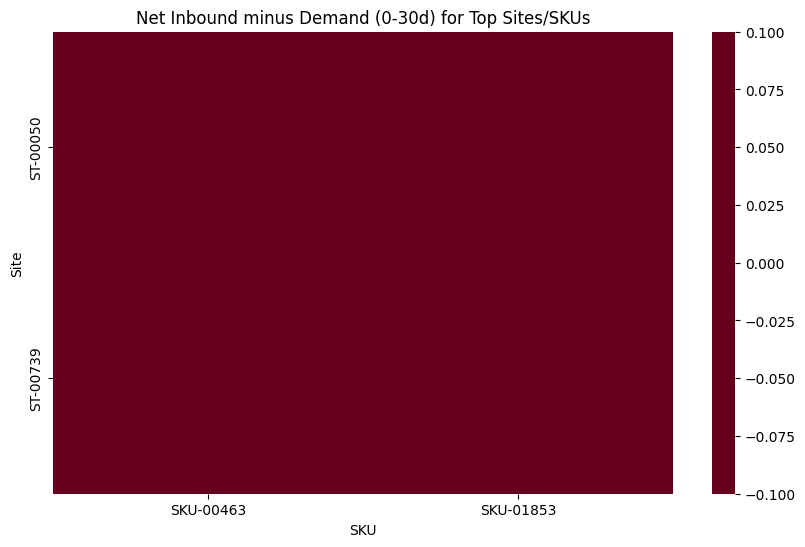

C:\Users\skibi\AppData\Local\Temp\ipykernel_37832\3064062536.py:59: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  bucket_long = bucket_df.melt(id_vars="bucket", variable_name="series", value_name="units").to_pandas()


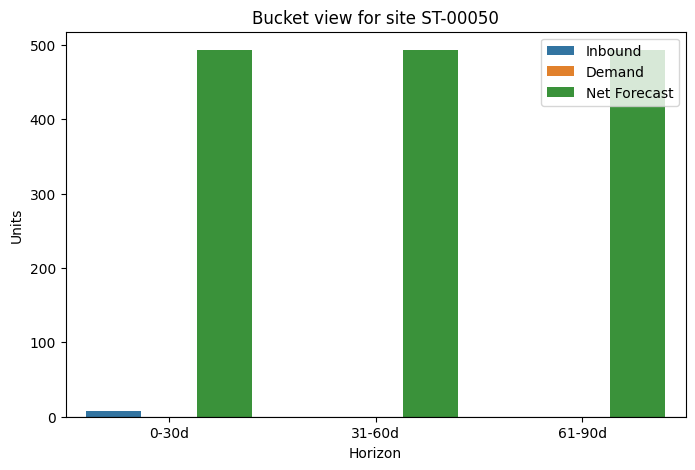

In [129]:
# Visual summaries: net-flow heatmap and focus site bucket view
heatmap_base = forecast_full.with_columns(
    (pl.col("inbound_0-30d") - pl.col("demand_0-30d")).alias("net_flow_0_30")
)
top_sites = site_rollup.head(12)["site"].to_list() if site_rollup.height > 0 else []
top_skus = (
    heatmap_base
    .with_columns(pl.col("net_flow_0_30").abs().alias("abs_flow"))
    .sort("abs_flow", descending=True)
    .select("sku")
    .unique()
    .head(12)["sku"].to_list()
    if heatmap_base.height > 0
    else []
)

heatmap_df = (
    heatmap_base
    .filter(pl.col("site").is_in(top_sites) & pl.col("sku").is_in(top_skus))
    .select(["site", "sku", "net_flow_0_30"])
)

if not heatmap_df.is_empty():
    heatmap_pd = heatmap_df.to_pandas().pivot_table(index="site", columns="sku", values="net_flow_0_30", fill_value=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_pd, cmap="RdBu", center=0)
    plt.title("Net Inbound minus Demand (0-30d) for Top Sites/SKUs")
    plt.xlabel("SKU")
    plt.ylabel("Site")
    plt.show()
else:
    print("Heatmap skipped: insufficient overlapping site/SKU pairs.")

focus_site = top_sites[0] if top_sites else None
if focus_site is not None:
    focus_summary = (
        forecast_full
        .filter(pl.col("site") == focus_site)
        .select([
            pl.sum("inbound_0-30d").alias("inbound_0_30"),
            pl.sum("inbound_31-60d").alias("inbound_31_60"),
            pl.sum("inbound_61-90d").alias("inbound_61_90"),
            pl.sum("demand_0-30d").alias("demand_0_30"),
            pl.sum("demand_31-60d").alias("demand_31_60"),
            pl.sum("demand_61-90d").alias("demand_61_90"),
            pl.sum("forecast_0-30d").alias("forecast_0_30"),
            pl.sum("forecast_31-60d").alias("forecast_31_60"),
            pl.sum("forecast_61-90d").alias("forecast_61_90")
        ])
    )
    if not focus_summary.is_empty():
        focus_pd = focus_summary.to_pandas().iloc[0]
        bucket_df = pl.DataFrame({
            "bucket": ["0-30d", "31-60d", "61-90d"],
            "Inbound": [focus_pd["inbound_0_30"], focus_pd["inbound_31_60"], focus_pd["inbound_61_90"]],
            "Demand": [focus_pd["demand_0_30"], focus_pd["demand_31_60"], focus_pd["demand_61_90"]],
            "Net Forecast": [focus_pd["forecast_0_30"], focus_pd["forecast_31_60"], focus_pd["forecast_61_90"]]
        })
        bucket_long = bucket_df.melt(id_vars="bucket", variable_name="series", value_name="units").to_pandas()
        plt.figure(figsize=(8, 5))
        sns.barplot(data=bucket_long, x="bucket", y="units", hue="series")
        plt.title(f"Bucket view for site {focus_site}")
        plt.ylabel("Units")
        plt.xlabel("Horizon")
        plt.axhline(0, color="black", linewidth=0.8)
        plt.legend(loc="best")
        plt.show()
else:
    print("Focus site plot skipped: no eligible sites found.")

## LightGBM-assisted 30d inventory forecast
To complement the deterministic buckets, we train a supervised model that learns non-linear interactions between stock, inbound, demand, and categorical identifiers. The model predicts the 30-day net inventory position and surfaces feature importance so we can compare drivers across sites.

In [130]:
# Build training matrix from forecast outputs
ml_ready = (
    forecast_full
    .with_columns([
        (pl.col("inbound_0-30d") - pl.col("demand_0-30d")).alias("net_flow_0_30"),
        (pl.col("inbound_31-60d") - pl.col("demand_31-60d")).alias("net_flow_31_60"),
        (pl.col("inbound_61-90d") - pl.col("demand_61-90d")).alias("net_flow_61_90"),
        (pl.col("inbound_0-30d") + pl.col("inbound_31-60d") + pl.col("inbound_61-90d")).alias("total_inbound"),
        (pl.col("demand_0-30d") + pl.col("demand_31-60d") + pl.col("demand_61-90d")).alias("total_demand"),
        pl.when(pl.col("demand_0-30d") > 0)
        .then(pl.col("inbound_0-30d") / pl.col("demand_0-30d"))
        .otherwise(0.0)
        .alias("inbound_to_demand_ratio")
    ])
    .drop_nulls()
 )

feature_cols = [
    "effective_stock",
    "inbound_0-30d",
    "inbound_31-60d",
    "inbound_61-90d",
    "demand_0-30d",
    "demand_31-60d",
    "demand_61-90d",
    "net_flow_0_30",
    "net_flow_31_60",
    "net_flow_61_90",
    "total_inbound",
    "total_demand",
    "inbound_to_demand_ratio"
 ]
target_col = "forecast_0-30d"

ml_df = ml_ready.select(["site", "sku"] + feature_cols + [target_col]).to_pandas()
ml_df["site_cat"] = ml_df["site"].astype("category").cat.codes
ml_df["sku_cat"] = ml_df["sku"].astype("category").cat.codes
feature_cols_extended = feature_cols + ["site_cat", "sku_cat"]

if len(ml_df) >= 50:
    X_train, X_test, y_train, y_test = train_test_split(
        ml_df[feature_cols_extended],
        ml_df[target_col],
        test_size=0.25,
        random_state=42,
        shuffle=True
)
    gbm = lgb.LGBMRegressor(
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=64,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"LightGBM test MAE: {mae:0.2f}")
    print(f"LightGBM test R^2: {r2:0.3f}")
else:
    print("Not enough site/SKU samples to train LightGBM (need >= 50 rows).")
    gbm = None
    X_test = y_test = y_pred = None

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 36122, number of used features: 10
[LightGBM] [Info] Start training from score 8.484663
LightGBM test MAE: 0.02
LightGBM test R^2: 0.997


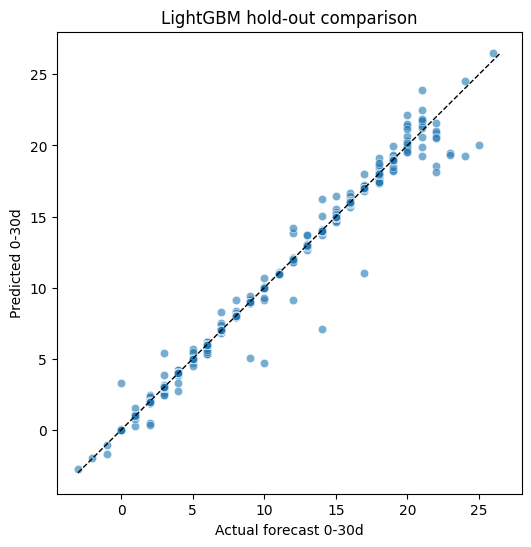

C:\Users\skibi\AppData\Local\Temp\ipykernel_37832\1883473844.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x="importance", y="feature", palette="viridis")


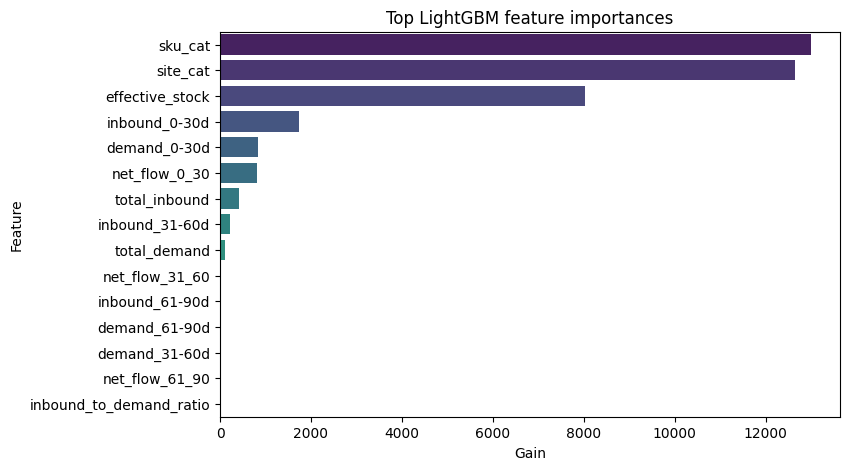


Largest absolute errors (top 10):
           site        sku  actual  prediction     error
46164  ST-01804  SKU-02453    14.0    7.118846  6.881154
47565  ST-00881  SKU-00112    17.0   11.065915  5.934085
32941  ST-01296  SKU-02020    10.0    4.722651  5.277349
48142  ST-00473  SKU-04165    25.0   20.019288  4.980712
48130  ST-00216  SKU-03549    24.0   19.284281  4.715719
28280  ST-01068  SKU-03257     9.0    5.074976  3.925024
48117  ST-01046  SKU-01952    22.0   18.163403  3.836597
48120  ST-00781  SKU-03078    23.0   19.356038  3.643962
48122  ST-00762  SKU-00286    23.0   19.495040  3.504960
48102  ST-00117  SKU-03485    22.0   18.541978  3.458022


In [131]:
# Visualize LightGBM performance and drivers
if gbm is not None and isinstance(X_test, pd.DataFrame):
    comparison_df = (
        ml_df.loc[X_test.index, ["site", "sku", target_col]]
        .assign(prediction=y_pred)
        .rename(columns={target_col: "actual"})
    )
    comparison_df["error"] = comparison_df["actual"] - comparison_df["prediction"]
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=comparison_df, x="actual", y="prediction", alpha=0.6)
    lims = [min(comparison_df["actual"].min(), comparison_df["prediction"].min()), max(comparison_df["actual"].max(), comparison_df["prediction"].max())]
    plt.plot(lims, lims, linestyle="--", color="black", linewidth=1)
    plt.xlabel("Actual forecast 0-30d")
    plt.ylabel("Predicted 0-30d")
    plt.title("LightGBM hold-out comparison")
    plt.show()

    importance_df = pd.DataFrame({
        "feature": feature_cols_extended,
        "importance": gbm.feature_importances_
    }).sort_values("importance", ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=importance_df.head(15), x="importance", y="feature", palette="viridis")
    plt.title("Top LightGBM feature importances")
    plt.xlabel("Gain")
    plt.ylabel("Feature")
    plt.show()

    print("\nLargest absolute errors (top 10):")
    print(comparison_df.reindex(comparison_df["error"].abs().sort_values(ascending=False).index).head(10))
else:
    print("LightGBM diagnostics skipped: model did not train.")